импорт всех нужных библиотек

In [1]:
import torch
import sys
import os
from model import Trainer,Transformer
import numpy as np
#путь к корню директории
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.abspath(BASE_DIR))
from data_preparation import PreparationDataset
from show_analysis import LossVisualizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Загрузка и подготовка данных для анализа и обучения модели.<br>
разбиение на train,test


In [2]:
path = BASE_DIR + '\data_all'  # Путь к данным
PD = PreparationDataset(path)

# параметры подготовки данных
pd_params = (10,9,50,1)
window_size,num_features,downsample_step,target_window_size = pd_params 

# Подготовка данных
X, y, df = PD.many_to_many(
    window_size,
    num_features,
    downsample_step,
    target_window_size,
    device=device  
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = PD.PDtrain_test_split(
    X, y, test_size=0.33, random_state=42
)

In [3]:
#инициализация модели
model = Transformer( 
    input_dim = X_train.shape[2], # num_features - 1
    hidden_dim = 64, # hidden_dim%num_heads == 0
    output_dim = target_window_size,
    num_heads = 4,
    num_layers = 1,
    dropout=0.3,
    device = device)

trainer = Trainer(
    model=model,
    learning_rate=0.01,
    device= device
)

In [4]:
history = trainer.fit(
    X=X_train,
    y=y_train,
    X_t=X_test,
    y_t=y_test,
    batch_size=32,
    epochs=200,
    loss_tube=5
)

Epoch 10
Main: 0.951648, MAPE: 0.527100
Test - MAPE: 0.531353, Tube: 0.071861
Epoch 20
Main: 0.954677, MAPE: 0.528095
Test - MAPE: 0.526728, Tube: 0.070311
Epoch 40
Main: 0.949516, MAPE: 0.521996
Test - MAPE: 0.521370, Tube: 0.069748
Epoch 60
Main: 0.946124, MAPE: 0.522796
Test - MAPE: 0.520349, Tube: 0.070030
Epoch 80
Main: 0.946555, MAPE: 0.526508
Test - MAPE: 0.519024, Tube: 0.070452
Epoch 100
Main: 0.947641, MAPE: 0.526651
Test - MAPE: 0.507984, Tube: 0.071439
Epoch 120
Main: 0.944745, MAPE: 0.525199
Test - MAPE: 0.519390, Tube: 0.069748
Epoch 140
Main: 0.945735, MAPE: 0.523429
Test - MAPE: 0.515790, Tube: 0.071298


KeyboardInterrupt: 

In [13]:
from model_history import ModelHistory
MH = ModelHistory(history)
MH.save_history_json(filename = BASE_DIR+'\loss_history/all_loss.json',model_name = 'Transformer')
# key = MH.add_result(
#         filename = BASE_DIR+'\\resualt/main.json',
#         model_name = 'Transformer',
#         result = 'last',
#         message = 'first',
#         params = {'input_dim': X_train.shape[2], # window_size*num_features - 1
#                   'hidden_dim': 128, # hidden_dim%num_heads == 0
#                   'output_dim': target_window_size,
#                   'num_heads': 8,
#                   'num_layers': 3,
#                   'lr':0.001,
#                   'batch_size':32}
#         )
# key

In [7]:
LV = LossVisualizer(history)

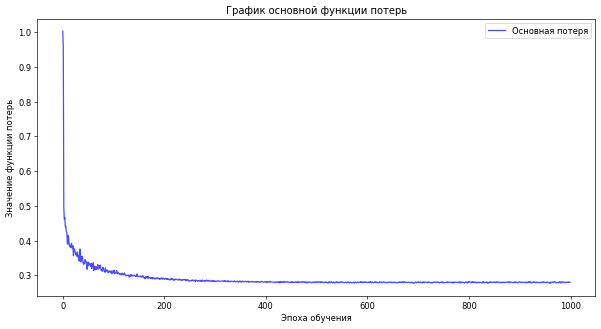

In [8]:
LV.show_training_loss()

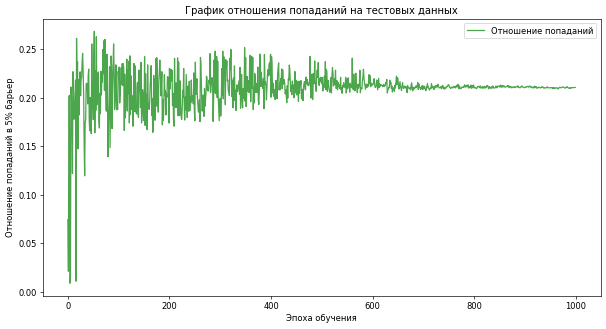

In [9]:
LV.show_test_tube()

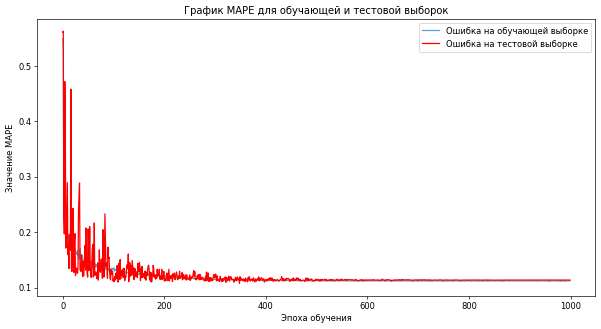

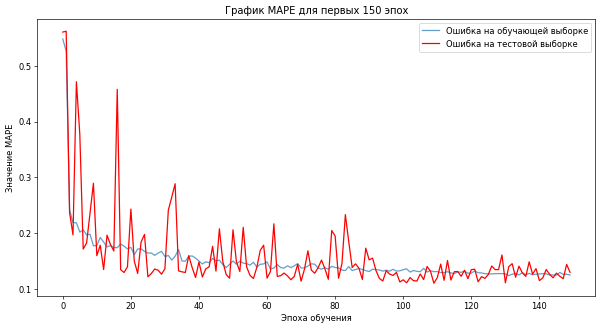

In [10]:
LV.show_mape()

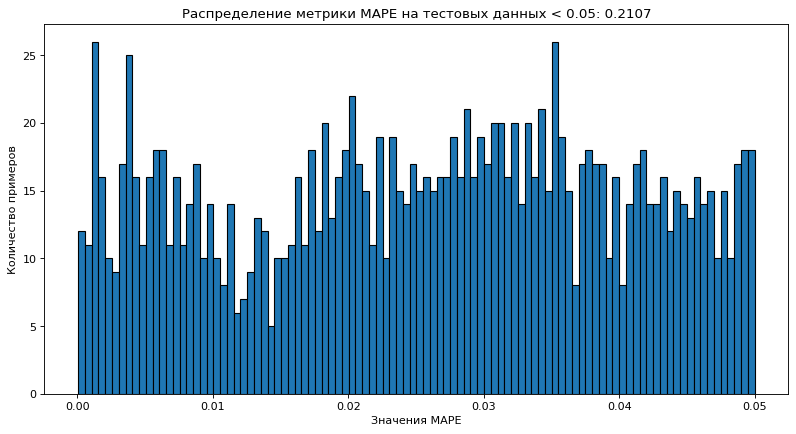

Процент значений MAPE < 0.05: 0.2107


In [11]:
LV.histogram_mape(model,X_test,y_test,limit_percel = 5)

Количество записей: 5334


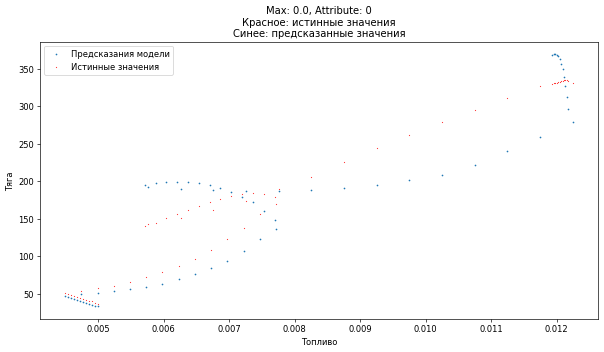

Количество записей: 5334


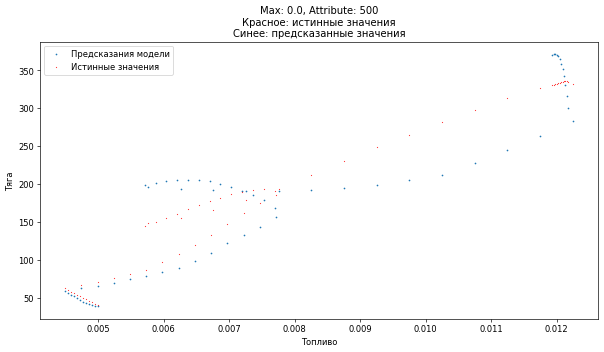

Количество записей: 5334


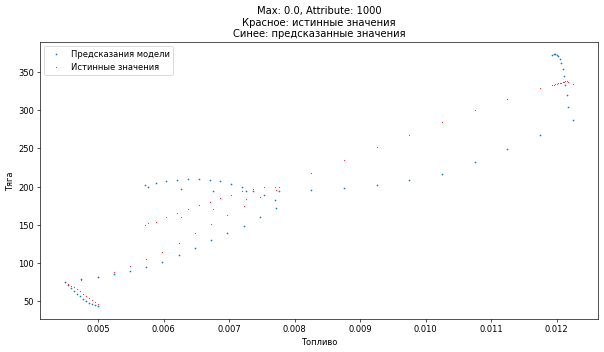

Количество записей: 5334


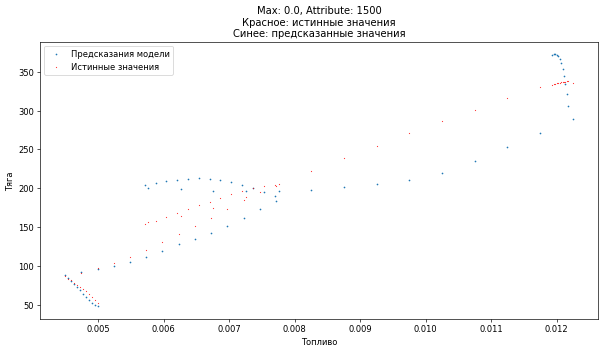

Количество записей: 5334


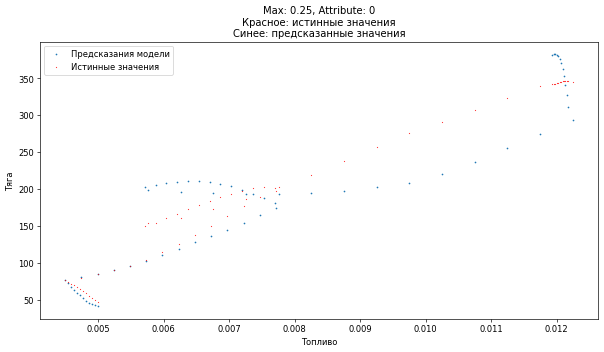

Количество записей: 5334


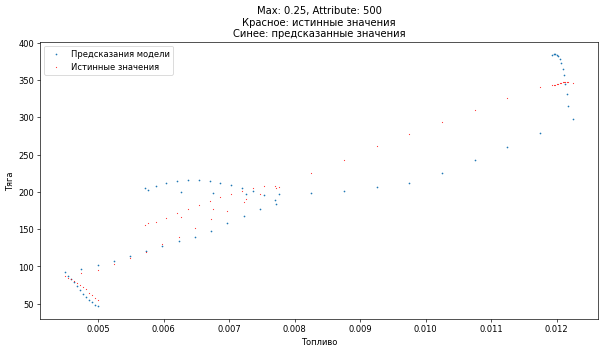

Количество записей: 5334


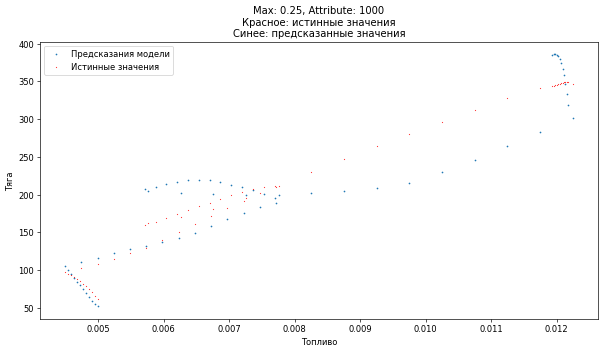

Количество записей: 5334


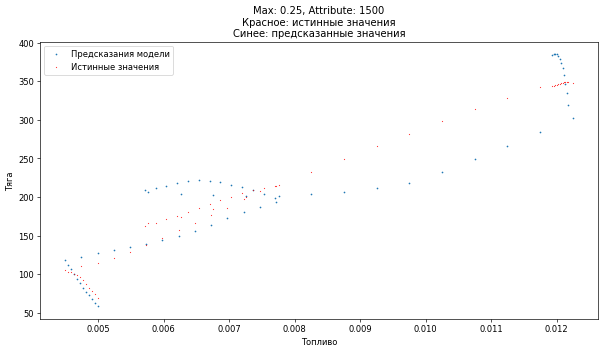

Количество записей: 5334


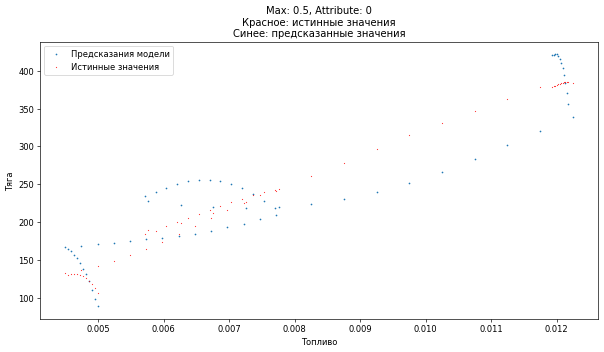

Количество записей: 5334


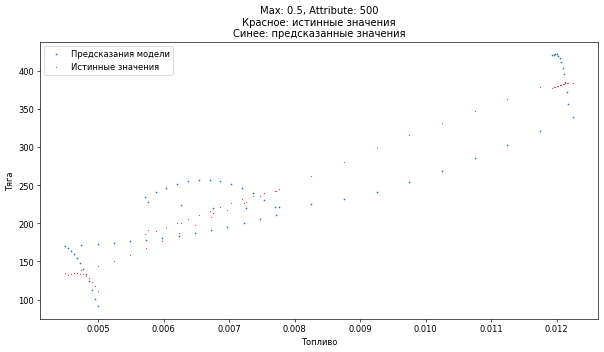

Количество записей: 5334


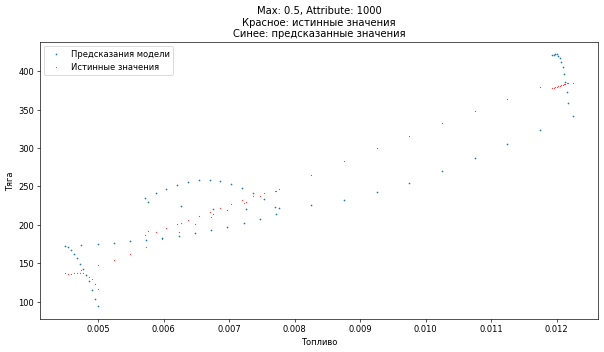

Количество записей: 5334


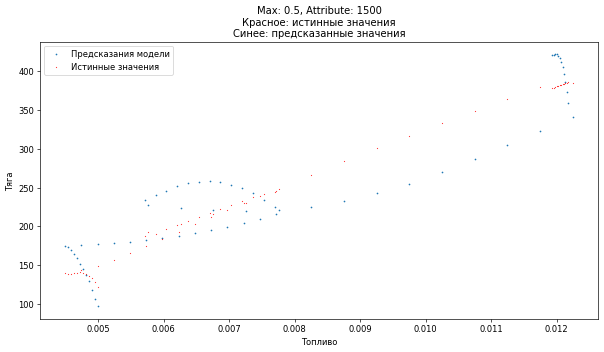

Количество записей: 5334


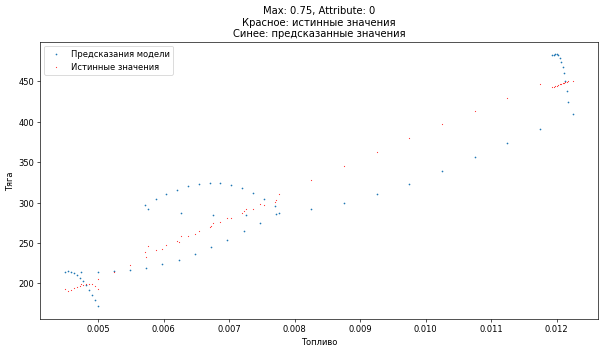

Количество записей: 5334


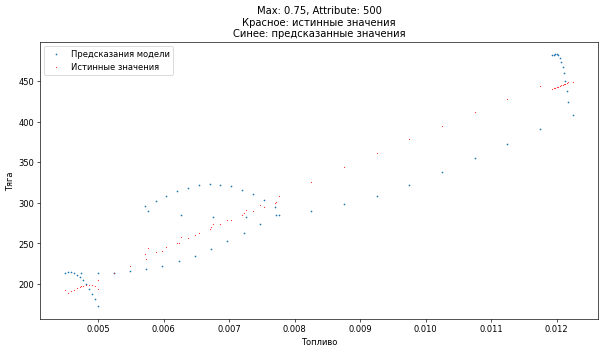

Количество записей: 5334


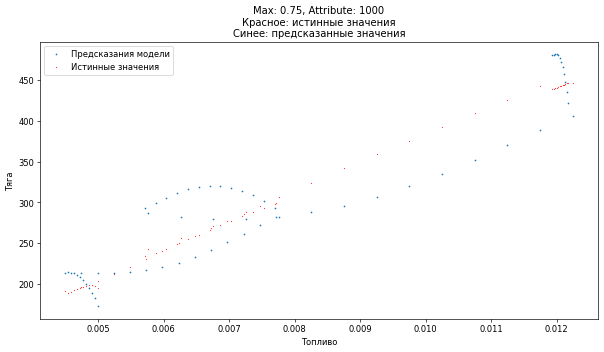

Количество записей: 5334


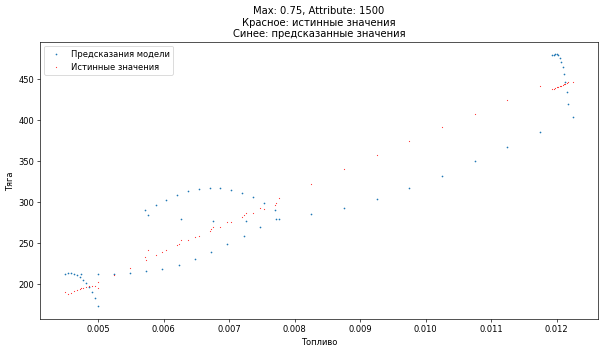

Количество записей: 5334


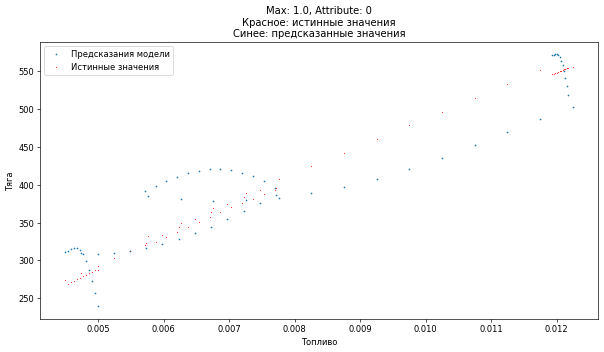

Количество записей: 5334


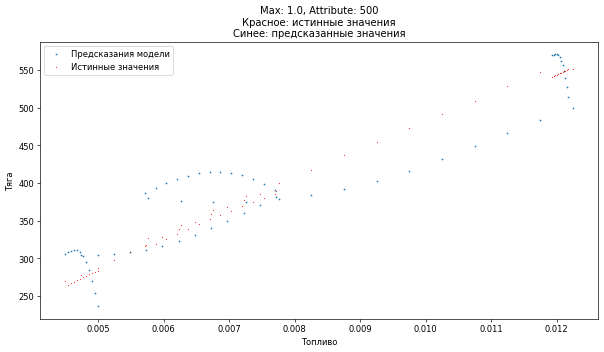

Количество записей: 5334


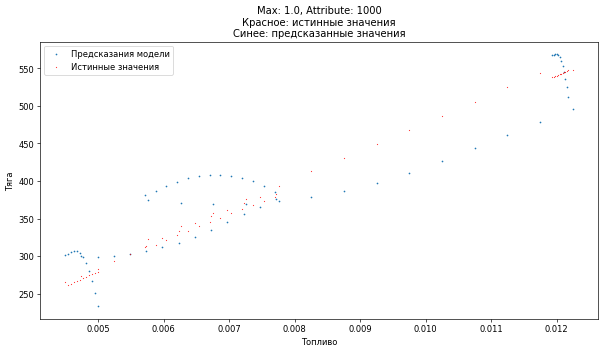

Количество записей: 5334


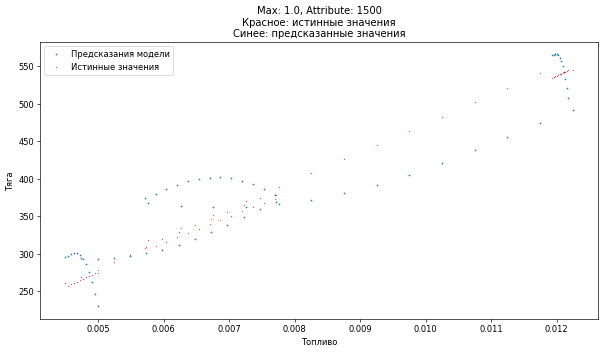

In [12]:
LV.show_predictions_rnn(model,df,pd_params,keras=False,device=device)